In [1]:
# Se importa drive para acceder a los repositorios de datos en Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [116]:
# Se importan las distintas librerías que se usarán

import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn import set_config
set_config(display='diagram')
import scipy.cluster.hierarchy as sch
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras import metrics
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [117]:
# Se crea el dataframe y se toman los datos desde un archivo de extensión csv que tengo en Drive

filename = '/content/drive/MyDrive/CargaData/CargaML/cars.csv'
dfAutos = pd.read_csv(filename)

In [ ]:
# Se agregaron los nombres de las columnas ya que que no venían
dfAutos.columns =['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model year', 'origin', 'brand'] 
dfAutos.head()

In [ ]:
# Vemos toda la información relacionada a la cantidad de filas y columnas, tipos de dato, nombres de columnas y si hay datos nulos 
dfAutos.info()

In [120]:
# Se revisaron los datos y se identificó que en la columna venía un caracter extraño. Era el caracter ?. Se hizo un replace por cero y después se convirtió el tipo de dato a int 64.
dfAutos['horsepower'] = dfAutos['horsepower'].replace('?', 0)
dfAutos['horsepower'] = dfAutos['horsepower'].astype('int64')

In [ ]:
# En este dataset los datos iguales a cero se interpretan como falta de información por la naturaleza de los datos y considerar ceros en los datos sería un error que entregaría resultados basados en premisas erróneas. 
# Ej. Un auto no puede tener 0 cilindro o una cilindrada de 0. Tampoco puede tener 0 caballos de fuerza ni tiempo de aceleración de 0 a 60 mph de 0 segundos. 
# Por lo anterior, se revisaron una a una las columnas en busca de datos en cero y los resultados fueron los siguientes:

datosCero = dfAutos[dfAutos['mpg'] == 0] # NO HAY
datosCero = dfAutos[dfAutos['cylinders'] == 0] # NO HAY
datosCero = dfAutos[dfAutos['displacement'] == 0] # NO HAY
datosCero = dfAutos[dfAutos['horsepower'] == 0] # 6
datosCero = dfAutos[dfAutos['weight'] == 0] # NO HAY
datosCero = dfAutos[dfAutos['acceleration'] == 0] # NO HAY
datosCero = dfAutos[dfAutos['model year'] == 0] # NO HAY
datosCero = dfAutos[dfAutos['origin'] == 0] # NO HAY

dfAutos = dfAutos[dfAutos['horsepower'] != 0]
dfAutos
# Solo en la columna horsepower habían ceros por el replace del caracter extraño hecho anteriormente. A continuación esos datos se eliminaron para no afectar el conjunto de datos.
# Se eliminó el 1,51% de los datos, quedando para análisis el 98,49% (391 filas)


In [ ]:
# Se detectó 1 fila repetida. El 91% de los datos son iguales, siendo la única diferencia el año. La fila se elimina.

dfAutos = dfAutos[~((dfAutos['mpg'] == 27) & (dfAutos['cylinders'] == 4) & (dfAutos['displacement'] == 97) & (dfAutos['horsepower'] == 88) & (dfAutos['weight'] == 2130) & (dfAutos['acceleration'] == 14.5) & (dfAutos['model year'] == 71))]
dfAutos.info()

Todas las columnas numéricas quedaron con tipo de dato numérico (int o float) y se eliminaron los datos cero, limpiando de esa manera los datos. Ahora, el dataframe está listo para continuar trabajando en él.  

In [123]:
# Se crean dos variables para separar los datos de la matriz y los datos de la columna Target u Objetivo 

X = dfAutos.drop(columns = ['mpg']) # MATRIZ
y = dfAutos['mpg'] # TARGET U OBJETIVO

# Se hace train test split en los datos. Se utiliza el número 42 por coherencia.
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42) # Con grupo de datos de validación evitamos Data Leaking

In [124]:
# Se crean selectores identificando las columnas de categorías y las numéricas
cat_selector = make_column_selector(dtype_include='object')
num_selector = make_column_selector(dtype_include='number')

# LOS DATOS YA FUERON LIMPIADOS Y NO HAY DATOS EN BLANCO, FALTANTES O EN CERO, POR LO TANTO NO ES NECESARIO AGREGAR IMPUTERS 
# Imputers: Más frecuente y Media
# freq_imputer = SimpleImputer(strategy='most_frequent')
# mean_imputer = SimpleImputer(strategy='mean')

# Scaler
scaler = StandardScaler()

# One-hot encoder
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

In [ ]:
# Pipelines Numéricos
numeric_pipe = make_pipeline(scaler)
numeric_pipe

In [ ]:
# Pipelines de Categorías
categorical_pipe = make_pipeline(ohe)
categorical_pipe

In [ ]:
# Tuples para Column Transformer
number_tuple = (numeric_pipe, num_selector)
category_tuple = (categorical_pipe, cat_selector)

# ColumnTransformer
preprocessor = make_column_transformer(number_tuple, category_tuple, remainder = 'passthrough')
preprocessor

In [128]:
#Transformando datos
preprocessor.fit(X_train)

# transform train and test
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)


In [ ]:
# Comprobar que los datos se escalen y tengan una codificación one-hot

print('All data in X_train_processed are', X_train_processed.dtype)
print('All data in X_test_processed are', X_test_processed.dtype)
print('Shape of data is', X_train_processed.shape, '\n')
print('DATOS TRAIN PROCESADOS', X_train_processed, '\n')
print('DATOS TEST PROCESADOS ', X_test_processed)

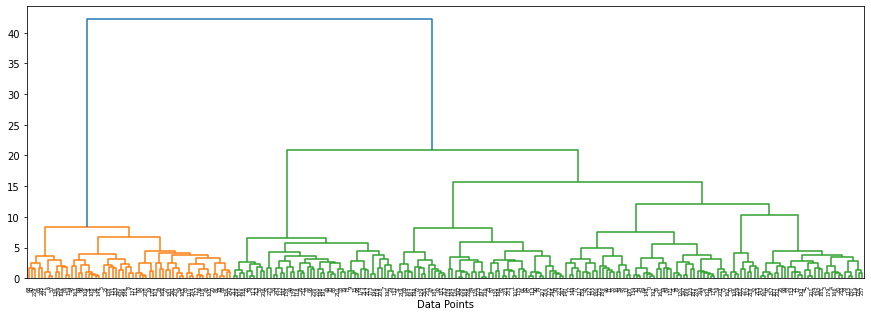

In [130]:
plt.figure(figsize = (15, 5))
sch.dendrogram(sch.linkage(X_train_processed, method = 'ward'))
plt.xlabel('Data Points');

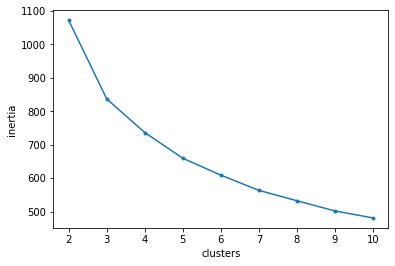

In [131]:
#Create an empty list of inertias
inertias = []
#Loop through k values between 2 and 10 and store the inertias in the list.
for k in range(2,11):  
    kmeans = KMeans(n_clusters=k)  
    kmeans.fit(X_train_processed)  
    inertias.append(kmeans.inertia_)
#Visualize scores
plt.plot(range(2,11), inertias, marker = '.')
plt.xlabel('clusters')
plt.ylabel('inertia');

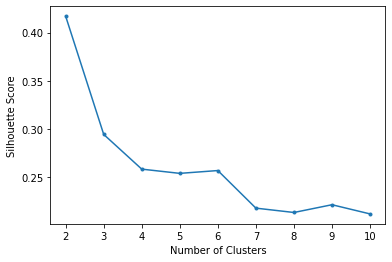

In [132]:
# Visualize different silhouette scores
# Save silhouette scores for various cluster numbers in list
silhouette_scores = []
for i in range(2, 11):
  kmeans = KMeans(n_clusters = i)
  kmeans.fit(X_train_processed)
  silhouette_scores.append(silhouette_score(X_train_processed, kmeans.labels_))
# Visualize scores
plt.plot(range(2, 11), silhouette_scores, marker = '.')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score');

In [133]:
# Análisis visto en https://login.codingdojo.com/m/504/12411/86825
# Fit kmeans model with 2 clusters and display the silhouette score
kmeans = KMeans(n_clusters = 2, max_iter=3)
kmeans.fit(X_train_processed)
silhouette_score(X_train_processed, kmeans.labels_) #0.41690014198681535

0.41690014198681535

In [140]:
kmeans = KMeans(n_clusters=2, random_state=42, max_iter=3)
kmeans.fit(X_train_processed)
# Add the clusters as a column in the dataframe
X_train['cluster'] = kmeans.labels_
X_train.head()

,cylinders,displacement,horsepower,weight,acceleration,model year,origin,brand,cluster
196,4,90.0,70,1937,14.2,76,2,volkswagen,0
203,4,85.0,70,1990,17.0,76,3,datsun,0
372,4,140.0,92,2865,16.4,82,1,ford,0
218,4,122.0,96,2300,15.5,77,1,plymouth,0
337,4,135.0,84,2490,15.7,81,1,plymouth,0


In [136]:
cluster_groups = X_train.groupby('cluster', as_index=False).mean()
cluster_groups

,cluster,cylinders,displacement,horsepower,weight,acceleration,model year,origin
0,0,4.532609,139.320652,85.092391,2585.097826,16.522826,76.755435,1.815217
1,1,7.969231,349.861538,162.200000,4175.769231,12.776923,73.753846,1.000000


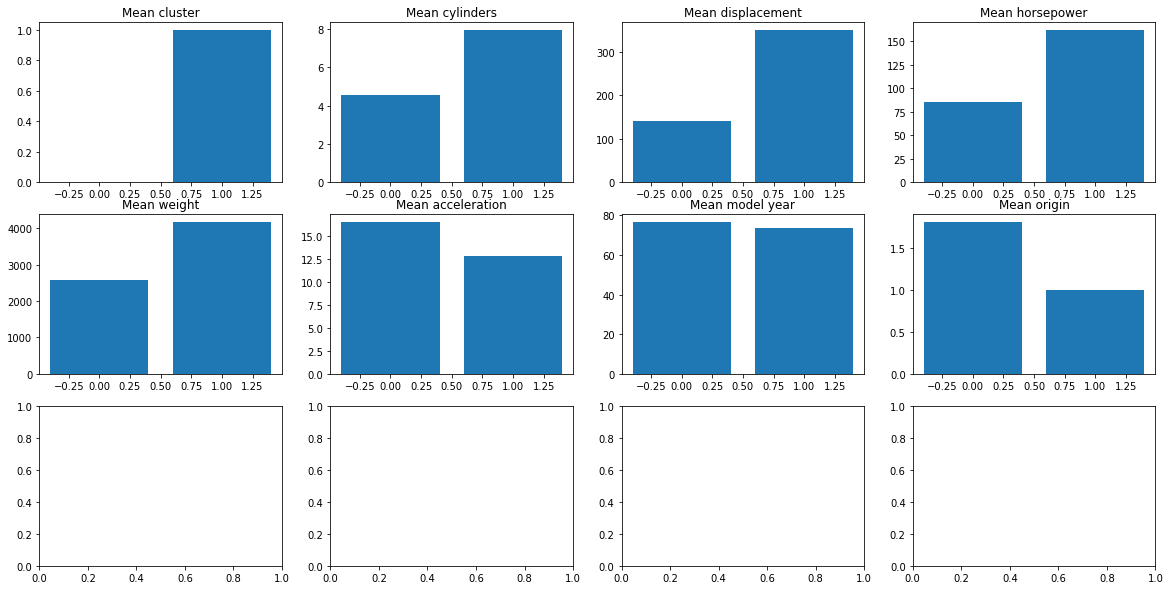

In [22]:
# Visualize means 
fig, axes = plt.subplots(3,4, figsize = (20, 10))
# fig is an array of dimensions 3,4.  axes.ravel() will flatten it to 12,1
axes = axes.ravel()
# Loop over columns and plot each in a separate figure, skip 'cluster' column
for i, col in enumerate(cluster_groups.columns[0:]):
  axes[i].bar(cluster_groups['cluster'], cluster_groups[col])
  axes[i].set_title(f'Mean {col}')

In [67]:
# Vemos la cantidad de columnas que toma con PCA
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_processed)

print("El número de columnas que considera CON PCA es", pca.n_components_, "de", pca.n_features_)

El número de columnas que considera CON PCA es 13 de 36


In [26]:
# Vemos la cantidad de columnas que toma sin PCA
pca = PCA()
X_train_no_pca = pca.fit_transform(X_train_processed)

print("El número de columnas que considera SIN PCA es", pca.n_components_, "de", pca.n_features_)

El número de columnas que considera SIN PCA es 36 de 36


In [68]:
# Visto en clase
# Definir tu modelo secuencial de base
# Modelo sin 
model = Sequential()

input_shape = X_train_pca.shape[1]
print('Input shape:', input_shape)

# First hidden layer
model.add(Dense(800, # How many neurons you have in your first hidden layer
                input_dim = input_shape, # What is the shape of your input features (number of columns)
                activation = 'relu')) # What activation function are you using?
# Second hidden layer
model.add(Dense(500, # How many neurons you have in your second hidden layer
                activation = 'relu')) # What activation function are you using?
# Output layer --> Esta capa de salida tiene 1 sola neurona y siempre se trabaja con 1 y función sigmoide al tener un problema de clasificación
model.add(Dense(1, activation = 'linear')) 

model.compile(loss = 'mse', optimizer = 'adam', metrics=['mae', 'mse'])
model.summary()

Input shape: 13
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_45 (Dense)            (None, 800)               11200     
                                                                 
 dense_46 (Dense)            (None, 500)               400500    
                                                                 
 dense_47 (Dense)            (None, 1)                 501       
                                                                 
Total params: 412,201
Trainable params: 412,201
Non-trainable params: 0
_________________________________________________________________


In [70]:
predicted_batch = X_train_pca[:10]
predicted_result = model.predict(predicted_batch)
predicted_result

array([[ 0.01595654],
       [ 0.0814031 ],
       [ 0.01977063],
       [ 0.0333224 ],
       [ 0.03312714],
       [-0.04638752],
       [-0.08361628],
       [-0.03153902],
       [-0.09202699],
       [-0.04923834]], dtype=float32)

In [71]:
# https://www.tensorflow.org/tutorials/keras/regression
history = model.fit(X_train_pca, y_train, epochs=80, validation_split = 0.2)

Epoch 1/80
7/7 [==============================] - 0s 21ms/step - loss: 543.6108 - mae: 21.9716 - mse: 543.6108 - val_loss: 434.2406 - val_mae: 19.1629 - val_mse: 434.2406
Epoch 2/80
7/7 [==============================] - 0s 6ms/step - loss: 345.2693 - mae: 16.7092 - mse: 345.2693 - val_loss: 217.4835 - val_mae: 13.0819 - val_mse: 217.4835
Epoch 3/80
7/7 [==============================] - 0s 6ms/step - loss: 145.7768 - mae: 10.5794 - mse: 145.7768 - val_loss: 60.9047 - val_mae: 6.7320 - val_mse: 60.9047
Epoch 4/80
7/7 [==============================] - 0s 8ms/step - loss: 40.2855 - mae: 5.3371 - mse: 40.2855 - val_loss: 39.3482 - val_mae: 5.1485 - val_mse: 39.3482
Epoch 5/80
7/7 [==============================] - 0s 6ms/step - loss: 41.3313 - mae: 5.1313 - mse: 41.3313 - val_loss: 29.1307 - val_mae: 4.4535 - val_mse: 29.1307
Epoch 6/80
7/7 [==============================] - 0s 6ms/step - loss: 21.1257 - mae: 3.6387 - mse: 21.1257 - val_loss: 19.7191 - val_mae: 3.5427 - val_mse: 19.7191


In [61]:
results = model.evaluate(X_test_processed, y_test, batch_size=128)

1/1 [==============================] - 0s 82ms/step - loss: 10.2141 - mae: 2.1834 - mse: 10.2141


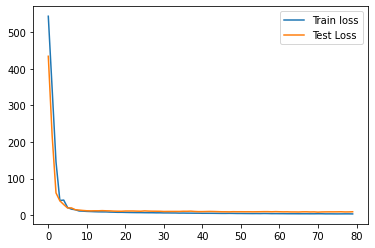

In [72]:
# Visualize the loss
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.legend();

Input shape: 13
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_70 (Dense)            (None, 4000)              56000     
                                                                 
 dense_71 (Dense)            (None, 3500)              14003500  
                                                                 
 dense_72 (Dense)            (None, 2500)              8752500   
                                                                 
 dense_73 (Dense)            (None, 1000)              2501000   
                                                                 
 dense_74 (Dense)            (None, 1)                 1001      
                                                                 
Total params: 25,314,001
Trainable params: 25,314,001
Non-trainable params: 0
_________________________________________________________________
Epoch 1/80
7/7 [=========

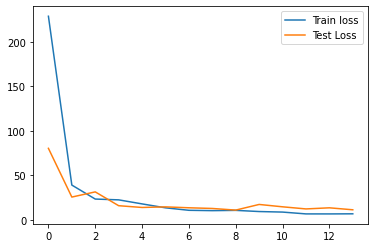

In [79]:
# Con Early Stopping
model1 = Sequential()

input_shape = X_train_pca.shape[1]
print('Input shape:', input_shape)

# First hidden layer
model1.add(Dense(4000, # How many neurons you have in your first hidden layer
                input_dim = input_shape, # What is the shape of your input features (number of columns)
                activation = 'relu')) # What activation function are you using?
# Second hidden layer
model1.add(Dense(3500, # How many neurons you have in your second hidden layer
                activation = 'relu')) # What activation function are you using?
# Third hidden layer
model1.add(Dense(2500, # How many neurons you have in your first hidden layer
                input_dim = input_shape, # What is the shape of your input features (number of columns)
                activation = 'relu')) # What activation function are you using?
# Fourth hidden layer
model1.add(Dense(1000, # How many neurons you have in your second hidden layer
                activation = 'relu')) # What activation function are you using?
# Output layer --> Esta capa de salida tiene 1 sola neurona y siempre se trabaja con 1 y función sigmoide al tener un problema de clasificación
model1.add(Dense(1, activation = 'linear')) 

model1.compile(loss = 'mse', optimizer = 'adam', metrics=['mae', 'mse'])
early_stopping = EarlyStopping(patience = 5)

model1.summary()
history = model1.fit(X_train_pca, y_train, epochs=80, validation_split = 0.2, callbacks = [early_stopping])

# Visualize the loss
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.legend();

Input shape: 13
Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_99 (Dense)            (None, 3000)              42000     
                                                                 
 dense_100 (Dense)           (None, 2500)              7502500   
                                                                 
 dense_101 (Dense)           (None, 1)                 2501      
                                                                 
Total params: 7,547,001
Trainable params: 7,547,001
Non-trainable params: 0
_________________________________________________________________
Epoch 1/80
7/7 [==============================] - 1s 76ms/step - loss: 598.5412 - mae: 17.1543 - mse: 367.4014 - val_loss: 273.1238 - val_mae: 6.6490 - val_mse: 65.0928
Epoch 2/80
7/7 [==============================] - 0s 53ms/step - loss: 261.0385 - mae: 6.7014 - mse: 67.6952 - val_loss: 2

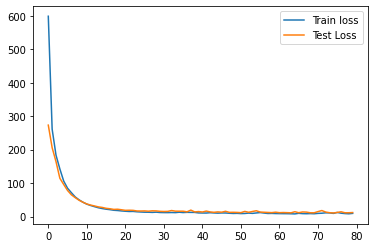

In [88]:
# Con L2
model2 = Sequential()

input_shape = X_train_pca.shape[1]
print('Input shape:', input_shape)

# First hidden layer
model2.add(Dense(3000, # How many neurons you have in your first hidden layer
                input_dim = input_shape, # What is the shape of your input features (number of columns)
                activation = 'relu',
                kernel_regularizer=l2(0.09))) # What activation function are you using?
# Second hidden layer
model2.add(Dense(2500, # How many neurons you have in your second hidden layer
                activation = 'relu',
                kernel_regularizer=l2(0.09))) # What activation function are you using?
# Output layer --> Esta capa de salida tiene 1 sola neurona y siempre se trabaja con 1 y función sigmoide al tener un problema de clasificación
model2.add(Dense(1, activation = 'linear')) 
model2.compile(loss = 'mse', optimizer = 'adam', metrics=['mae', 'mse'])
model2.summary()
history = model2.fit(X_train_pca, y_train, epochs=80, validation_split = 0.2)

# Visualize the loss
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.legend();

In [ ]:
# INSTANCIA DEL MODELO
dec_tree = DecisionTreeRegressor(max_depth = 7, random_state = 42)  
# SE DEBE BUSCAR LA PROFUNDIDAD MÁXIMA A MANO PARA ELEGIR LA QUE MEJOR SE ADECÚA

dec_tree.get_params() # SE MUESTRAN TODOS LOS PARÁMETROS

In [ ]:
# AJUSTAR EL MODELO A DATOS DE ENTRENAMIENTO
dec_tree.fit(X_train_processed, y_train)

In [104]:
# PREDICCIONES
train_preds = dec_tree.predict(X_train_processed)
test_preds = dec_tree.predict(X_test_processed)

In [105]:
# EVALUACIÓN DEL MODELO
train_score = dec_tree.score(X_train_processed, y_train)
test_score = dec_tree.score(X_test_processed, y_test)
print('Dec Tree Train Score', train_score)
print('Dec Tree Test Score', test_score)

dec_tree_train_mae = mean_absolute_error(y_train, train_preds)
dec_tree_test_mae = mean_absolute_error(y_test, test_preds)

print('Dec Tree EAM Train', dec_tree_train_mae)
print('Dec Tree EAM Test', dec_tree_test_mae)

#7. EVALUAR EL MODELO USANDO EL ERROR CUADRÁTICO MEDIO (ECM)
dectree_mse_train = mean_squared_error(y_train, train_preds)
dectree_mse_test = mean_squared_error(y_test, test_preds)

print('MSE Train', dectree_mse_train)
print('MSE Test', dectree_mse_test)

#8. EVALUAR EL MODELO USANDO LA RAÍZ DEL ERROR CUADRÁTICO MEDIO (RECM)
dectree_rmse_train = np.sqrt(mean_squared_error(y_train, train_preds))
dectree_rmse_test = np.sqrt(mean_squared_error(y_test, test_preds))

print('RMSE Train', dectree_rmse_train)
print('RMSE Test', dectree_rmse_test)


Dec Tree Train Score 0.9762138656681376
Dec Tree Test Score 0.7715364508969077
Dec Tree EAM Train 0.8009351692484225
Dec Tree EAM Test 2.594635265010326
MSE Train 1.4219584050487664
MSE Test 14.733589881810326
RMSE Train 1.1924589741575038
RMSE Test 3.8384358639698966


In [ ]:
#4. SE INSTANCIA MODELO DE REGRESIÓN LINEAL
reg = LinearRegression()

#4. SE AJUSTA EL MODELO A LOS DATOS DE ENTRENAMIENTO
reg.fit(X_train_processed,y_train)

In [100]:
# Obtengan las predicciones del conjunto de entrenamiento
train_preds = reg.predict(X_train_processed)
# Obtengan las predicciones del conjunto de prueba
test_preds = reg.predict(X_test_processed)

#COEFICIENTE DE DETERMINACIÓN SKLEARN
r2_train = r2_score(y_train, train_preds)
r2_test = r2_score(y_test, test_preds)

print('R2 Train', r2_train) #SON LOS MISMOS NÚMEROS CON AMBOS R^2
print('R2 Test', r2_test) #SON LOS MISMOS NÚMEROS CON AMBOS R^2

#6. EVALUAR EL MODELO USANDO EL ERROR ABSOLUTO MEDIO (EAM)
eam_train = mean_absolute_error(y_train, train_preds)
eam_test = mean_absolute_error(y_test, test_preds)

print('EAM Train', eam_train)
print('EAM Test', eam_test)

#7. EVALUAR EL MODELO USANDO EL ERROR CUADRÁTICO MEDIO (ECM)
mse_train = mean_squared_error(y_train, train_preds)
mse_test = mean_squared_error(y_test, test_preds)

print('MSE Train', mse_train)
print('MSE Test', mse_test)

#8. EVALUAR EL MODELO USANDO LA RAÍZ DEL ERROR CUADRÁTICO MEDIO (RECM)
rmse_train = np.sqrt(mean_squared_error(y_train, train_preds))
rmse_test = np.sqrt(mean_squared_error(y_test, test_preds))

print('RMSE Train', rmse_train)
print('RMSE Test', rmse_test)

R2 Train 0.8555085469398317
R2 Test -9.757505496798774e+17
EAM Train 2.3156014683734942
EAM Test 898189411.7031121
MSE Train 8.637840570058211
MSE Test 6.292604873894836e+19
RMSE Train 2.939020341892552
RMSE Test 7932594073.75345


Los modelos que se utilizaron fueron los siguientes:
- Modelo Secuencial sin Regularización
- Modelo Secuencial con Early Stopping
- Modelo Secuencial con Regularización L2
- Árbol de Decisión (Regresión)
- Modelo de Regresión Lineal

De todos los modelos que se trabajaron se obtuvieron indicadores tales como el MAE, RMSE, R2 y MSE. Estos indicadores se revisaron y se fueron ajustando hiperparámetros en pro de lograr los mejores resultados posibles. El modelo que presentó por lejos los mejores resultados tanto en Train como en Test fue el Árbol de Decisión, bastante conocido y altamente utilizado, junto con el modelo de Regresión Lineal que, esta vez, no presentó buenos resultados, a diferencia del Árbol de Decisión.

DECISION TREE
Dec Tree Train Score 0.9762138656681376
Dec Tree Test Score 0.7715364508969077
Dec Tree EAM Test 2.594635265010326
MSE Test 14.733589881810326
RMSE Test 3.8384358639698966

LINEAR REGRESSION
R2 Train 0.8555085469398317
R2 Test -9.757505496798774e+17
EAM Test 898189411.7031121
MSE Test 6.292604873894836e+19
RMSE Test 7932594073.75345